## Spatial Tuning: Response Patterns

This notebook corresponds to Section 3.4.2 of the thesis.
In the following, we analyse the recorded ROIs' RF heat maps using response patterns.


The computation and visualisation is based on code from a jupyter-notebook on visualising receptive fields, which can be found in the Allen Institute's OpenScope-Databook: https://alleninstitute.github.io/openscope_databook/first-order/receptive_fields.html (last accessed 12.09.2025)

### Step 1: Import Data And Dependencies

In [4]:
import warnings
warnings.filterwarnings('ignore')

try:
    from openscope_databook.databook_utils.dandi_utils import dandi_stream_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

import sys
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import remfile
import h5py
import openscope_databook.databook_utils.dandi_utils

from dandi import dandiapi
from nwbwidgets import nwb2widget
import pynwb
from pynwb import NWBHDF5IO
from IPython.display import display, HTML

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate


from helpers import *

%matplotlib inline

filepath = "sub-731327_ses-2025+01+30-vsync-new_ophys.nwb"

# Use NWBHDF5IO to read the local NWB file instead of dandi_stream_open
io = NWBHDF5IO(filepath, 'r')
nwb = io.read()

gabor_stim_table = nwb.intervals['receptive_field_block_presentations_vsync'][:]
xs = np.sort(list(set(map(float, gabor_stim_table.x_position))))
ys = np.sort(list(set(map(float, gabor_stim_table.y_position))))[::-1]


graphColour = (137/255, 0/255, 225/255)


# define data we want to look at:
dff_timestamps, dff_trace = get_dff_any(nwb, "VISp_0")
interp_hz = 10
dff_trace = interpolate_dff(dff_trace, dff_timestamps, interp_hz)
dff_timestamps = np.arange(dff_timestamps[0], dff_timestamps[-1], step=(1/interp_hz))

gabor_stim_table = nwb.intervals['receptive_field_block_presentations_vsync'][:]

### Step 2: Define Auxiliary Functions

In [15]:
# compute all per stimulus responses, i.e. the response pattern

def getResponseOverTrials(traces, dff_timestamps, stim_table, shift=0.2):
    responses = []
    for j in range(stim_table.shape[0]):
        start_time = stim_table.iloc[j]["start_time"] + shift # sihft integration window
        end_time = stim_table.iloc[j]["stop_time"] + shift
        start_idx, end_idx = np.searchsorted(dff_timestamps, (start_time, end_time))
        response = traces[start_idx:end_idx].mean()
       
        responses.append(response)

    return np.array(responses)

In [12]:
# plots specific ROI's dff trace throughout the experiment, its response pattern and its RF heat map

def plotRoiProfile(roi_no, shift=0.2, savefilename="", figX=10, figY=5):
    fig, axes = plt.subplots(1, 3, figsize=(figX, figY))
   
    axes[0].set_title("Activity throughout experiment")
    axes[0].plot(dff_trace[:, roi_no], color=graphColour, linewidth=0.5)
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("$\Delta$F/F")

    axes[1].set_title("Activity per Stimulus Presentation")
    axes[1].plot(getResponseOverTrials(dff_trace[:, roi_no], dff_timestamps, gabor_stim_table, shift=shift), color=graphColour, linewidth=0.5)
    axes[1].set_xlabel("Stimulus presentation no.")
    axes[1].set_ylabel("Per stimulus response ($\Delta F/F$)")
    #axes[1].set_ylabel("Mean $\Delta F/F$ from $t_{\\text{start}} + 0.2\\,s$ to $t_{\\text{stop}} + 0.2\\,s$")


    display_mask = getDisplayMask(gabor_stim_table)

    rf_heat_map = np.zeros((9,9))

    for j in range(gabor_stim_table.shape[0]):
        traces = dff_trace[:,roi_no]
        x, y = getRFcoords(gabor_stim_table.iloc[j]["x_position"], gabor_stim_table.iloc[j]["y_position"])

        #first get indices
        start_time = gabor_stim_table.iloc[j]["start_time"] + shift # shift integration window
        end_time = gabor_stim_table.iloc[j]["stop_time"] + shift
        start_idx, end_idx = np.searchsorted(dff_timestamps, (start_time, end_time))

        rf_heat_map[y, x] += traces[start_idx:end_idx].mean()

    rf_heat_map /= display_mask

    axes[2].set_title("RF heat map")
    imshow = axes[2].imshow(rf_heat_map, cmap='viridis', vmin=rf_heat_map.min(), vmax=rf_heat_map.max())
    cbar = fig.colorbar(imshow, ax=axes[2], shrink=0.5)
    cbar.set_label("Location response ($\Delta$F/F)")
    axes[2].set_xlabel("deg X")
    axes[2].set_ylabel("deg Y")
    axes[2].set_xticks(range(len(xs)), xs, rotation=90, fontsize=8)
    axes[2].set_yticks(range(len(ys)), ys, fontsize=8)
    
    plt.tight_layout()

    if not savefilename == "":
        plt.savefig("PATHNAME", bbox_inches='tight')

    plt.show()
    return fig


In [13]:
# show RF heat map for all orientations, as well as orientation tuning curve

def plotRFforAllOrientations(roi_no, shift=0.2, savefilename="", figX=10, figY=5):
    orientations = sorted(gabor_stim_table["orientation"].unique())

    rf_heat_maps = np.zeros((3,9,9))

    fig, axes = plt.subplots(1, 4, figsize=(figX, figY))

    for idx, orientation in enumerate(orientations):
        rf_heat_map = np.zeros((9,9))
        stim_table = gabor_stim_table[gabor_stim_table["orientation"]==orientation]
        display_mask = getDisplayMask(stim_table)

        for j in range(stim_table.shape[0]):


            x, y = getRFcoords(stim_table.iloc[j]["x_position"], stim_table.iloc[j]["y_position"])

            #first get indices
            start_time = stim_table.iloc[j]["start_time"] + shift # shift integration window
            end_time = stim_table.iloc[j]["stop_time"] + shift
            start_idx, end_idx = np.searchsorted(dff_timestamps, (start_time, end_time))

            response = dff_trace[:,roi_no][start_idx:end_idx].mean()

            rf_heat_map[y, x] += response

        rf_heat_map /= display_mask

        rf_heat_maps[idx,:,:] = rf_heat_map

    vmax = rf_heat_maps.max()
    vmin = rf_heat_maps.min()

    for idx, rf in enumerate(rf_heat_maps):
        imshow = axes[idx].imshow(rf, cmap='viridis', vmin=vmin, vmax=vmax)
        axes[idx].set_title(f"Orientation {orientations[idx]}°")
        axes[idx].set_xlabel("deg X")
        axes[idx].set_xticks(range(len(xs)), xs, rotation=90, fontsize=8)
        axes[idx].set_yticks(range(len(ys)), ys, fontsize=8)
        cbar = fig.colorbar(imshow, ax=axes[idx], fraction=0.025, pad=0.04)
        if idx == 2:
            cbar.set_label("location responses for orientation ($\Delta$F/F)")
        if idx == 0:
            axes[idx].set_ylabel("deg Y")
   
    tuning_vals = np.zeros(3)

    for idx,rf in enumerate(rf_heat_maps):
        tuning_vals[idx] = rf.sum()

    orientation_frequencies = np.array([966, 957, 957])
    tuning_vals /= orientation_frequencies

    axes[3].plot(orientations, tuning_vals, color=graphColour)
    axes[3].set_ylabel("Orientation response ($\Delta$F/F)")
    axes[3].set_xlabel("Orientation")
    axes[3].set_title("Orientation Tuning Curve")

    plt.tight_layout()

    if not savefilename == "":
        plt.savefig("PATHNAME", bbox_inches='tight')

    plt.show()


    return fig

In [11]:
# gives an overview of per stimulus responses at specific location

def plotResponsesAtLocation(roi_no, x ,y, onset=0.2, savefilename="", figX=10, figY=5):
    orientations = sorted(gabor_stim_table["orientation"].unique())
    responses = []

    x,y = float(x), float(y)

    maxVal = 0

    fig, axes = plt.subplots(1, 4, figsize=(figX, figY))

    for idx, orientation in enumerate(orientations):
        if idx > 2: 
            continue
        for j in range(gabor_stim_table.shape[0]):
            if gabor_stim_table.iloc[j]["orientation"] == orientation:
                x_stim, y_stim = gabor_stim_table.iloc[j]["x_position"], gabor_stim_table.iloc[j]["y_position"]
                x_stim, y_stim = float(x_stim), float(y_stim)

                if x_stim == x and y_stim == y:
                    start_time = gabor_stim_table.iloc[j]["start_time"] + onset
                    end_time = gabor_stim_table.iloc[j]["stop_time"] + onset
                    start_idx, end_idx = np.searchsorted(dff_timestamps, (start_time, end_time))
                    response = dff_trace[:,roi_no][start_idx:end_idx].mean()
                    responses.append(response)

        axes[idx].plot(np.array(responses), 'x', color=graphColour)
        axes[idx].set_title(f"Orientation {orientation}° at ({x}°,{y}°)")
        axes[idx].set_xticks([])
        axes[idx].set_xlabel("Stimulus Presentations")

        mean = np.array(responses).mean()
        meanArr = np.full_like(np.array(responses), mean)
        axes[idx].plot(meanArr, color=graphColour, linestyle='--')
        axes[idx].text(8.5, mean+0.75, 'average', fontsize=9, color='grey', verticalalignment='center')

        if idx == 0:
            axes[idx].set_ylabel("Per stimulus response ($\Delta F/F$)")

        if np.array(responses).max() > maxVal:            
            maxVal = np.array(responses).max()

        responses = []

    for i in range(axes.shape[-1]-1):
        axes[i].set_ylim(-2, maxVal + 1)

    rf_heat_map = np.zeros((9,9))
    
    x_rf_heat_map, y_rf_heat_map = getRFcoords(x, y)
    
    rf_heat_map[y_rf_heat_map, x_rf_heat_map] = 1

    axes[3].imshow(rf_heat_map, cmap="grey_r")
    axes[3].set_title(f"Location in Receptive Field")
    axes[3].set_xlabel("deg X")
    axes[3].set_ylabel("deg Y")
    axes[3].set_xticks(range(len(xs)), xs, rotation=90, fontsize=8)
    axes[3].set_yticks(range(len(ys)), ys, fontsize=8)

    plt.tight_layout()

    if not savefilename == "":
        plt.savefig("PATHNAME", bbox_inches='tight')

    plt.show()    

    return fig

In [9]:
# classifies a response patterns into multi-peak, low-count-peak or fluctuating

def classifyResponsePattern(responses):
    mean = responses.mean()
    std = responses.std()
    peakIndices = []
    for valIdx, val in enumerate(responses):
        if val > mean + 5*std:
            peakIndices.append(valIdx)
    #print("peaks:\t" + str(peakIndices) + "\n")
    spacedPeakIndices = []
    if len(peakIndices) <= 1:
        spacedPeakIndices = peakIndices
    else:
        for i in range(len(peakIndices)):
            if i < len(peakIndices)-1:
                if peakIndices[i]+1 < peakIndices[i+1]:
                    spacedPeakIndices.append(peakIndices[i])
    
    #print("spaced:\t"+ str(spacedPeakIndices) +"\n")
    
    peakNum = len(spacedPeakIndices)

    if peakNum == 0:
        response_pattern = "fluctuating"
    elif peakNum < 5:
        response_pattern = "low-count-peak"
    else:
        response_pattern = "multi-peak"

    return response_pattern, peakNum

In [10]:
# calculates and (optionally) plots response patterns; each response pattern category gets another colour surrounding the plot

def get_response_patterns_for_plane(nwb, plane, stim_table, plot=True):
    df = pd.DataFrame(columns=["Plane", "Roi", "Pattern"])
    single_counter = 0
    multi_counter = 0
    fluct_counter = 0
    dff_timestamps, dff_trace = get_dff_any(nwb, plane)
    dff_trace = interpolate_dff(dff_trace, dff_timestamps, 10)
    dff_timestamps = np.arange(dff_timestamps[0], dff_timestamps[-1], 1/10)

    if plot:
        n_plots = dff_trace.shape[1]
        cols = 4
        rows = int(np.ceil(n_plots/cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2.4))
        axes = axes.flatten()

    for i in range(dff_trace.shape[1]): #for every roi
        responses = getResponseOverTrials(dff_trace[:,i], dff_timestamps, stim_table)
        response_pattern, peakNum = classifyResponsePattern(responses)

        if response_pattern == "low-count-peak":
                single_counter +=1
        if response_pattern == "multi-peak":
            multi_counter +=1
        if response_pattern == "fluctuating":
            fluct_counter +=1

        data = {"Plane":[plane], "Roi":[i], "Pattern":[response_pattern]}
        data_df = pd.DataFrame(data)
        df = pd.concat([df, data_df], ignore_index=True)
        
        if plot:

            ax = axes[i]
            ax.plot(responses, color=graphColour)
            ax.set_title(f"ROI no. {i+1}, {peakNum} peaks")
            ax.set_xlabel("trial no.")
            
            if i % 4 == 0:
                ax.set_ylabel("response $\Delta$F/F")

            if response_pattern == "low-count-peak":
                for spine in ax.spines.values():
                    spine.set_edgecolor("red")
                    spine.set_linewidth(3) 
            if response_pattern == "multi-peak":
                for spine in ax.spines.values():
                    spine.set_edgecolor("green")
                    spine.set_linewidth(3)
            if response_pattern == "fluctuating":
                for spine in ax.spines.values():
                    spine.set_edgecolor("yellow")
                    spine.set_linewidth(3)
    
            
            
    if plot:
        for k in range(n_plots, len(axes)):
            fig.delaxes(axes[k])
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        #plt.savefig((f"figures/spatial_tuning/sparse_noise/{on_off}-RFs-{getRegionByPlane(plane)}.pdf"), bbox_inches = 'tight')
        _ = plt.show()

    return df

### Step 3: Compute and Visualise Response Patterns

Investigation of ROIs based on response patterns, as done in the thesis:

multi_peak:


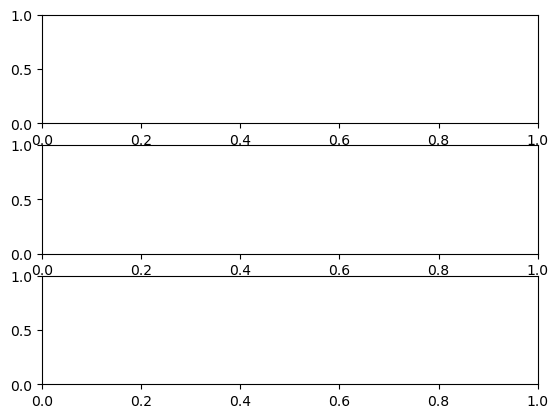

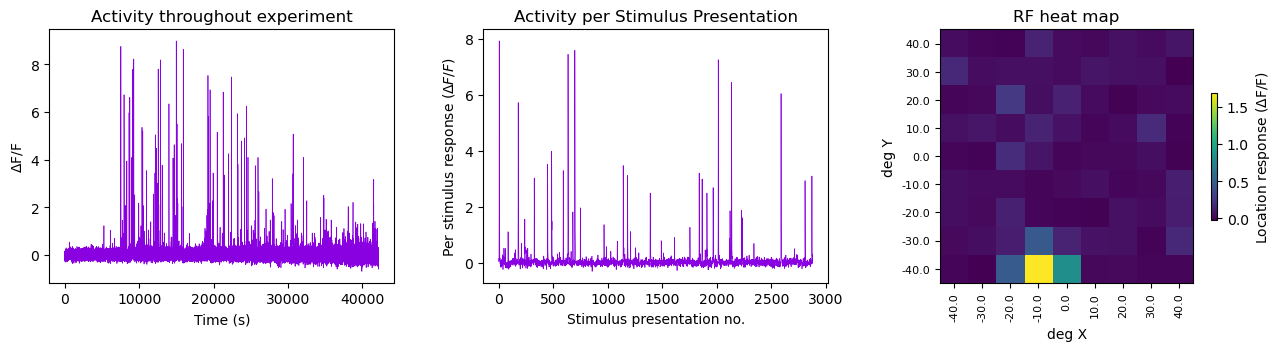

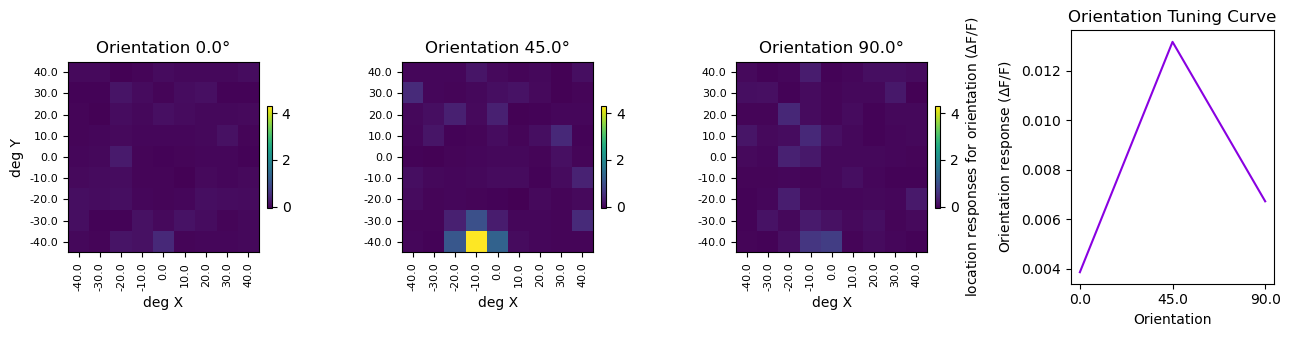

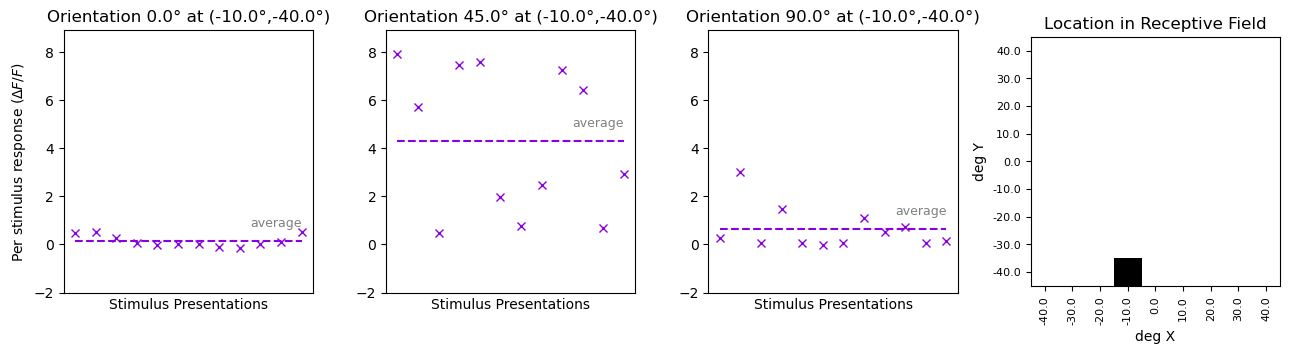

low-count-peak:


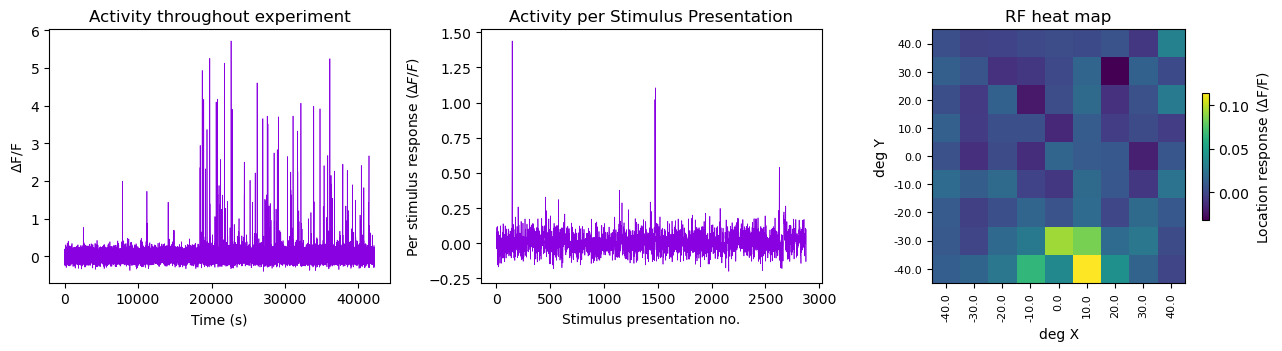

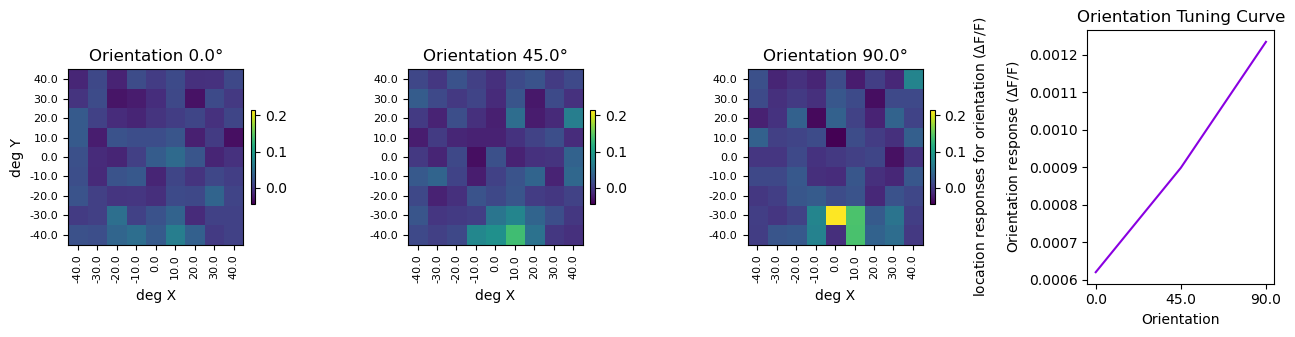

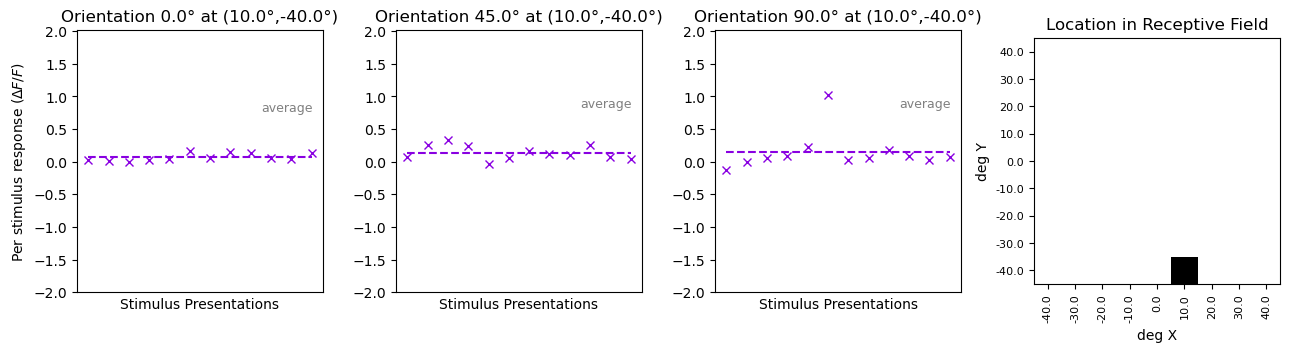

fluctuating:


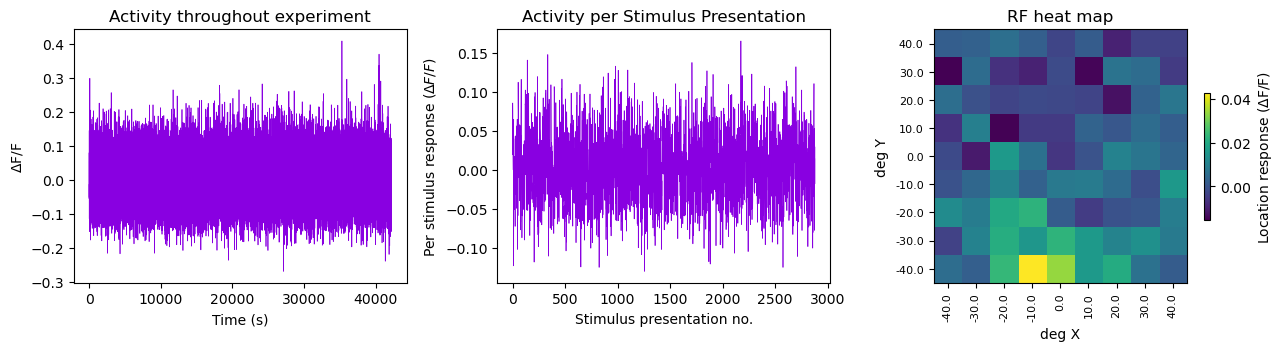

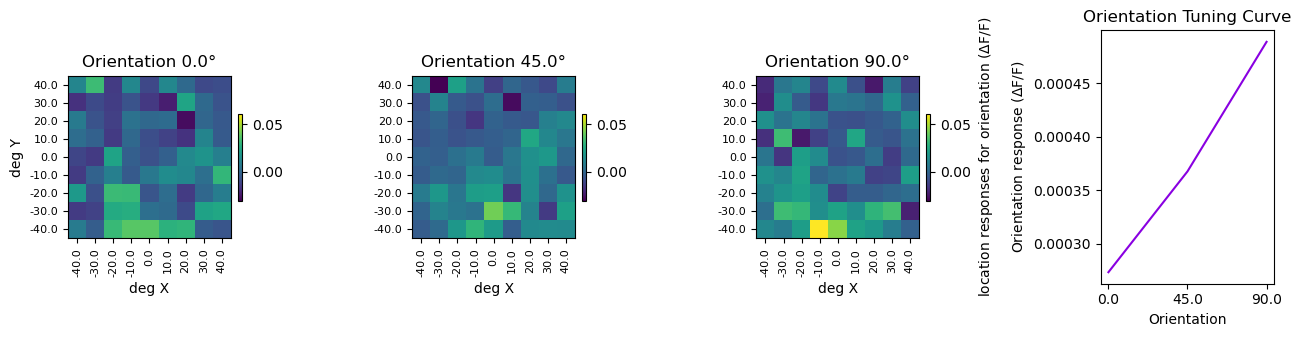

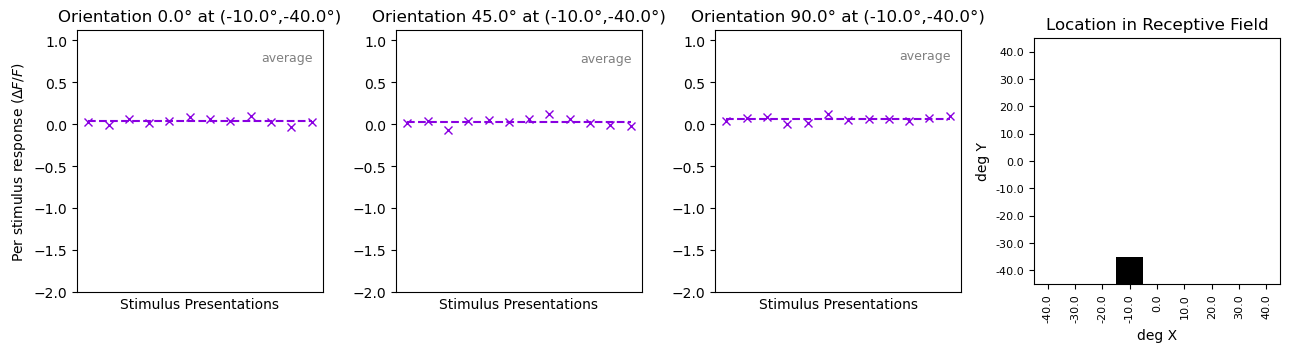

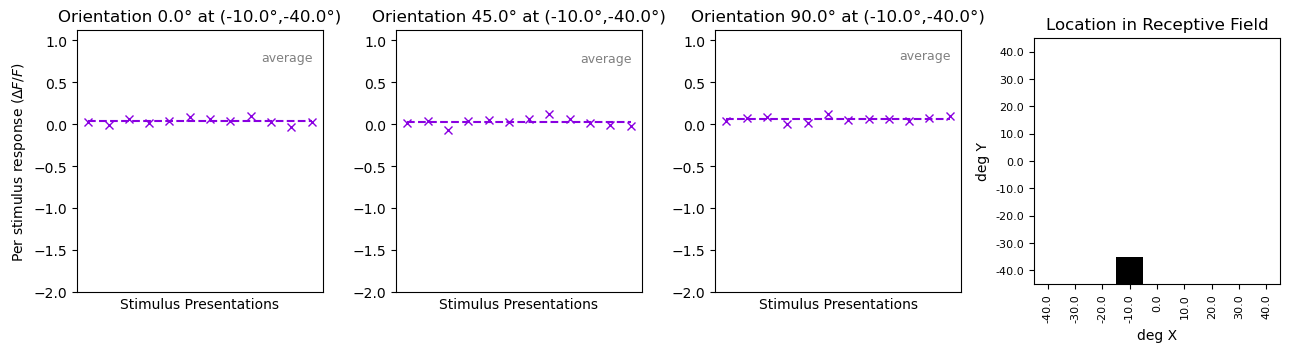

In [17]:
x = 13
y = 3.47
x3 = 13

print("multi_peak:")
fig, axes = plt.subplots(3,1)
axes[0] = plotRoiProfile(16, savefilename="", figX=x, figY=y)
plotRFforAllOrientations(16, savefilename="", figX=x3, figY=y)
plotResponsesAtLocation(16,-10,-40, savefilename="", figX=x3, figY=y)

print("low-count-peak:")
plotRoiProfile(14, savefilename="", figX=x, figY=y)
plotRFforAllOrientations(14, savefilename="", figX=x3, figY=y)
plotResponsesAtLocation(14, 10,-40, savefilename="", figX=x3, figY=y)

print("fluctuating:")
plotRoiProfile(34, savefilename="", figX=x, figY=y)
plotRFforAllOrientations(34, savefilename="", figX=x3, figY=y)
plotResponsesAtLocation(34,-10,-40, savefilename="", figX=x3, figY=y)

For each ROI individually, while also saving patterns to dataframe:

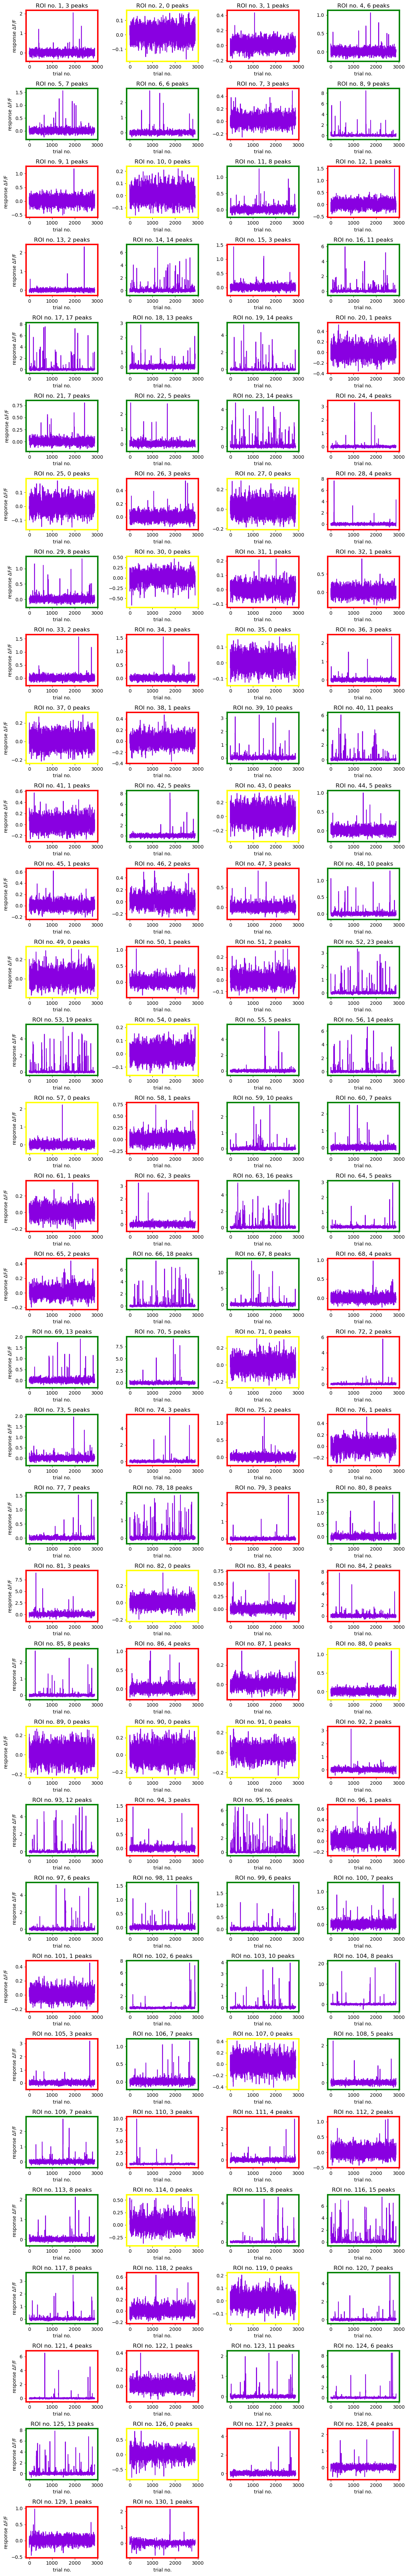

In [18]:
response_patterns_df = pd.DataFrame(columns=["Plane", "Roi", "Pattern"])

for plane in ["VISp_0"]:#nwb.imaging_planes.keys():
    cur_plane_df = get_response_patterns_for_plane(nwb, plane, gabor_stim_table, plot=True)
    response_patterns_df = pd.concat([response_patterns_df, cur_plane_df], ignore_index=True)